In [8]:
# Importing all the necessary libraries
import os
import fastf1
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from typing import Dict, Optional, Any, List, Tuple
import logging

In [9]:
# Set up cache for FastF1
def setup_fastf1_cache():
    """
    Create cache directory for FastF1 and enable caching
    """
    try:
        cache_dir = os.path.join(os.getcwd(), 'tire_strategy_cache') # Custom cache directory
        os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists
        fastf1.Cache.enable_cache(cache_dir) # Enable FastF1 cache in this directory
        print(f"FastF1 cache initialized and enabled at: {cache_dir}")
    except Exception as e:
        print(f"Failed to initialize FastF1 cache: {e}")

In [10]:
# Call cache 
setup_fastf1_cache()

FastF1 cache initialized and enabled at: c:\Users\amitn\OneDrive\Desktop\f1_project\tire_strategy_cache


In [11]:
# Configure logging for the application
def configure_logging(remove_timestamps=True):
    """
    Configure logging for the application, optionally removing timestamps.
    Includes function name and line number in log messages.
    
    Args:
        remove_timestamps (bool): If True, omit timestamps from logs.
    """
    # Reset all handlers to ensure clean logging configuration
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # Configure logging format
    if remove_timestamps:
        log_format = '%(levelname)s :: %(funcName)s :: %(lineno)d - %(message)s'
    else:
        log_format = '%(asctime)s - %(levelname)s :: %(funcName)s :: %(lineno)d - %(message)s'
    
    logging.basicConfig(level=logging.INFO, format=log_format)
    
    # Configure third-party library logging (like FastF1)
    fastf1_logger = logging.getLogger("fastf1")
    fastf1_logger.setLevel(logging.WARNING)  # Suppress lower levels like INFO
    for handler in fastf1_logger.handlers:
        if isinstance(handler, logging.StreamHandler):
            handler.setFormatter(logging.Formatter('%(levelname)s :: %(funcName)s :: %(lineno)d - %(message)s'))

# Call the function to remove timestamps globally
configure_logging(remove_timestamps=True)


In [12]:
# Full race classification dictionary
track_classification = {
    "Bahrain Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Balanced",
        "Power Sensitivity": "Medium"
    },
    "Saudi Arabian Grand Prix": {
        "Track Type": "Hybrid Circuit",
        "Length Classification": "Long",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "High"
    },
    "Australian Grand Prix": {
        "Track Type": "Street Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "High",
        "Power Sensitivity": "Medium"
    },
    "Emilia Romagna Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "High",
        "Power Sensitivity": "Medium"
    },
    "Miami Grand Prix": {
        "Track Type": "Hybrid Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Medium"
    },
    "Spanish Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "High",
        "Power Sensitivity": "Low"
    },
    "Monaco Grand Prix": {
        "Track Type": "Street Circuit",
        "Length Classification": "Short",
        "Aerodynamic Requirement": "Very High",
        "Power Sensitivity": "Low"
    },
    "Azerbaijan Grand Prix": {
        "Track Type": "Hybrid Circuit",
        "Length Classification": "Long",
        "Aerodynamic Requirement": "Low",
        "Power Sensitivity": "Very High"
    },
    "Canadian Grand Prix": {
        "Track Type": "Hybrid Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "High"
    },
    "Austrian Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Short",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Medium"
    },
    "British Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "High",
        "Power Sensitivity": "Medium"
    },
    "Hungarian Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Very High",
        "Power Sensitivity": "Low"
    },
    "French Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Medium"
    },
    "Belgian Grand Prix": {
        "Track Type": "Long Circuit",
        "Length Classification": "Long",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "High"
    },
    "Dutch Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Short",
        "Aerodynamic Requirement": "High",
        "Power Sensitivity": "Low"
    },
    "Italian Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Low",
        "Power Sensitivity": "Very High"
    },
    "Singapore Grand Prix": {
        "Track Type": "Street Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Very High",
        "Power Sensitivity": "Low"
    },
    "Japanese Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "High",
        "Power Sensitivity": "Medium"
    },
    "Qatar Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Medium"
    },
    "United States Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Medium"
    },
    "Mexican Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Short",
        "Aerodynamic Requirement": "Low",
        "Power Sensitivity": "High"
    },
    "Brazilian Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Short",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Medium"
    },
    "Abu Dhabi Grand Prix": {
        "Track Type": "Permanent Circuit",
        "Length Classification": "Medium",
        "Aerodynamic Requirement": "Medium",
        "Power Sensitivity": "Low"
    },
    "Las Vegas Grand Prix": {
        "Track Type": "Street Circuit",
        "Length Classification": "Long",
        "Aerodynamic Requirement": "Low",
        "Power Sensitivity": "High"
    }
}

In [13]:
def validate_race_input(season: int, race_name: str) -> bool:
    """
    Validate season and race name before processing.
    
    Args:
        season (int): Year of the race season
        race_name (str): Name of the race
        
    Returns:
        bool: True if inputs are valid
        
    Raises:
        ValueError: If season or race_name are invalid
    """
    try:
        logging.info(f"Validating inputs: Season={season}, Race Name={race_name}")
        
        # Define valid range of seasons
        valid_seasons = range(2022, 2025)  # Per project specifications
        if season not in valid_seasons:
            raise ValueError(f"Season {season} is not in the valid range {min(valid_seasons)}-{max(valid_seasons)}")
        
        # Check if race name is valid
        if race_name not in track_classification:
            raise ValueError(f"Race {race_name} not found in track classification.")
        
        logging.info("Input validation successful.")
        return True
    
    except ValueError as ve:
        logging.error(f"Validation error: {ve}")
        raise  # Re-raise the exception for the caller to handle
    
    except Exception as e:
        logging.error(f"Unexpected error during validation: {e}", exc_info=True)
        raise  # Re-raise any unexpected exceptions


In [14]:
def process_weather_data(weather_data: pd.DataFrame) -> Dict[str, Any]:
    """
    Process weather data to extract detailed metrics.
    
    Args:
        weather_data (pd.DataFrame): Raw weather data from FastF1
        
    Returns:
        Dict[str, Any]: Processed weather metrics
    """
    weather_metrics = {}
    
    # Handle case where weather_data is None or empty
    if weather_data is None or (isinstance(weather_data, pd.DataFrame) and weather_data.empty):
        return {
            "air_temperature": {
                "mean": "Unknown",
                "max": "Unknown",
                "min": "Unknown",
                "variance": "Unknown"
            },
            "track_temperature": {
                "mean": "Unknown",
                "max": "Unknown",
                "min": "Unknown",
                "variance": "Unknown"
            },
            "humidity": "Unknown",
            "weather_condition": "Unknown",
            "rainfall": {
                "probability": 0.0,
                "duration": 0
            }
        }
    
    # Temperature processing with explicit float conversion
    for temp_type in ['AirTemp', 'TrackTemp']:
        if temp_type in weather_data.columns:
            metrics = {
                'mean': float(round(weather_data[temp_type].mean(), 2)),
                'max': float(round(weather_data[temp_type].max(), 2)),
                'min': float(round(weather_data[temp_type].min(), 2)),
                'variance': float(round(weather_data[temp_type].std(), 2))
            }
            weather_metrics[temp_type.lower().replace('temp', '_temperature')] = metrics
    
    # Convert humidity to native float
    if 'Humidity' in weather_data.columns:
        weather_metrics['humidity'] = float(round(weather_data['Humidity'].mean(), 2))
    else:
        weather_metrics['humidity'] = "Unknown"
    
    # Convert rainfall values to native types
    if 'Rainfall' in weather_data.columns:
        weather_metrics['rainfall'] = {
            'probability': float(round(weather_data['Rainfall'].mean() * 100, 2)),
            'duration': int((weather_data['Rainfall'] > 0).sum())
        }
    else:
        weather_metrics['rainfall'] = {
            'probability': 0.0,
            'duration': 0
        }
    
    # Determine weather condition
    if 'Rainfall' in weather_data.columns:
        rain_threshold = 0.2
        weather_metrics['weather_condition'] = (
            "Heavy Rain" if weather_data['Rainfall'].mean() > rain_threshold * 2 else
            "Light Rain" if weather_data['Rainfall'].mean() > rain_threshold else
            "Sunny"
        )
    else:
        weather_metrics['weather_condition'] = "Unknown"
    
    return weather_metrics

In [15]:
def print_race_input(race_input: Dict[str, Any]) -> None:
    """
    Print race input data in a formatted, readable manner.
    
    Args:
        race_input (Dict[str, Any]): Dictionary containing race input data
    """
    print("\n=== Race Input Details ===\n")
    
    # Track Information
    print("Track Information:")
    track_info = race_input['Track Information']
    print(f"  Track Type: {track_info['Track Type']}")
    print(f"  Length Classification: {track_info['Length Classification']}")
    print(f"  Aerodynamic Requirement: {track_info['Aerodynamic Requirement']}")
    print(f"  Power Sensitivity: {track_info['Power Sensitivity']}")
    
    # Race Information
    print("\nRace Information:")
    race_info = race_input['Race Information']
    print(f"  Total Laps: {race_info['Total Laps']}")
    print(f"  Race Date: {race_info['Race Date']}")
    print(f"  Race Start Time: {race_info['Race Start Time']}")
    
    # Weather Information
    print("\nWeather Information:")
    weather = race_input['Weather Information']
    
    # Air Temperature
    print("  Air Temperature:")
    air_temp = weather['air_temperature']
    print(f"    Mean: {air_temp['mean']}°C")
    print(f"    Max: {air_temp['max']}°C")
    print(f"    Min: {air_temp['min']}°C")
    print(f"    Variance: {air_temp['variance']}°C")
    
    # Track Temperature
    print("  Track Temperature:")
    track_temp = weather['track_temperature']
    print(f"    Mean: {track_temp['mean']}°C")
    print(f"    Max: {track_temp['max']}°C")
    print(f"    Min: {track_temp['min']}°C")
    print(f"    Variance: {track_temp['variance']}°C")
    
    # Other Weather Metrics
    print(f"  Humidity: {weather['humidity']}%")
    print(f"  Weather Condition: {weather['weather_condition']}")
    print("  Rainfall:")
    print(f"    Probability: {weather['rainfall']['probability']}%")
    print(f"    Duration: {weather['rainfall']['duration']} laps")
    
    # Session Status
    print("\nSession Status:")
    status = race_input['Session Status']
    print(f"  Complete: {status['Complete']}")
    print(f"  Data Timestamp: {status['Data Timestamp']}")
    print("=" * 50)

In [16]:
def fetch_race_input(season: int, race_name: str) -> Dict[str, Any]:
    """
    Fetch comprehensive race input details, including track type, lap count, 
    detailed weather, and classifications.

    Args:
        season (int): Year of the race season (e.g., 2022)
        race_name (str): Name of the race (e.g., 'Bahrain Grand Prix')
        
    Returns:
        Dict[str, Any]: Dictionary with detailed race input information
        
    Raises:
        ValueError: If input validation fails
        Exception: For other errors during data fetching
    """
    try:
        logging.info(f"Fetching race input for: Season={season}, Race Name={race_name}")

        # Validate inputs
        validate_race_input(season, race_name)
        logging.info("Input validation successful.")

        # Load the race session
        logging.info(f"Loading session for {race_name} ({season})...")
        session = fastf1.get_session(season, race_name, 'R')
        session.load()
        logging.info("Session loaded successfully.")

        # Get track classification info
        track_info = track_classification.get(race_name, {
            "Track Type": "Unknown",
            "Length Classification": "Unknown",
            "Aerodynamic Requirement": "Unknown",
            "Power Sensitivity": "Unknown"
        })
        logging.info(f"Track classification info retrieved: {track_info}")

        # Process weather data
        weather_metrics = process_weather_data(session.weather_data)
        logging.info(f"Weather metrics processed: {weather_metrics}")

        # Create the enhanced race input dictionary
        race_input = {
            "Track Information": {
                "Track Type": track_info["Track Type"],
                "Length Classification": track_info["Length Classification"],
                "Aerodynamic Requirement": track_info["Aerodynamic Requirement"],
                "Power Sensitivity": track_info["Power Sensitivity"]
            },
            "Race Information": {
                "Total Laps": session.total_laps or "Unknown",
                "Race Date": session.date.strftime("%Y-%m-%d") if session.date else "Unknown",
                "Race Start Time": session.date.strftime("%H:%M:%S") if session.date else "Unknown"
            },
            "Weather Information": weather_metrics,
            "Session Status": {
                "Complete": session.total_laps is not None,
                "Data Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
        }

        # Log the formatted race input data
        logging.info("Race input details:")
        logging.info(race_input)

        # Only use the formatted print function
        print_race_input(race_input)

        return race_input

    except ValueError as ve:
        logging.error(f"Validation error: {ve}")
        error_data = {
            "Error": str(ve),
            "Race Name": race_name,
            "Season": season,
            "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        logging.error(f"Error details: {error_data}")
        raise

    except Exception as e:
        logging.error(f"Unexpected error occurred: {e}", exc_info=True)
        error_data = {
            "Error": str(e),
            "Race Name": race_name,
            "Season": season,
            "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        logging.error(f"Error details: {error_data}")
        return error_data


In [17]:
# NEEDS WORK
def fetch_pit_status_by_lap(session) -> pd.DataFrame:
    """
    Fetch pit status and map it to each lap in the session.
    
    Args:
        session: FastF1 session object
        
    Returns:
        pd.DataFrame: A DataFrame with LapNumber and PitStatus for each lap
    """
    try:
        logging.info("Fetching pit status data...")
        
        # Fetch track status data
        pit_status = session.get_pit_stop_data()

        # Extract pit status (in/out) for each lap
        pit_data = []
        for lap_number, pit_stop in pit_status.items():
            pit_data.append({
                'LapNumber': lap_number,
                'PitStatus': 'In' if pit_stop else 'Out'
            })

        # Create DataFrame from pit data
        pit_df = pd.DataFrame(pit_data)
        logging.info("Pit status data fetched successfully.")

        return pit_df

    except Exception as e:
        logging.error(f"Error in fetch_pit_status_by_lap: {e}", exc_info=True)
        return pd.DataFrame(columns=['LapNumber', 'PitStatus'])


In [18]:
def fetch_lap_and_stint_data(season: int, race_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetch lap-by-lap and stint-level data for a given race.

    Args:
        season (int): Year of the race season (e.g., 2022)
        race_name (str): Name of the race (e.g., 'Bahrain Grand Prix')
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (lap_data, stint_data)
            - lap_data: DataFrame containing lap-by-lap information
            - stint_data: DataFrame containing aggregated stint information
    """
    try:
        logging.info(f"Loading session for {race_name} ({season})...")
        
        # Step 1: Load the race session
        session = fastf1.get_session(season, race_name, 'R')
        session.load()
        logging.info(f"Session loaded successfully for {race_name} ({season}).")

        # Step 2: Extract lap-level data with error handling
        laps = session.laps
        logging.info("Extracting lap-level data from session.")

        # Define required columns and handle missing columns
        required_columns = ['LapNumber', 'Driver', 'Compound', 'LapTime', 
                            'Sector1Time', 'Sector2Time', 'Sector3Time']
        missing_columns = [col for col in required_columns if col not in laps.columns]
        if missing_columns:
            logging.warning(f"Missing required columns: {missing_columns}. Returning empty DataFrames.")
            return pd.DataFrame(), pd.DataFrame()

        # Create a copy of the data with only required columns
        lap_data = laps[required_columns].copy()

        # Convert time columns to seconds
        time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
        for col in time_columns:
            if col in lap_data.columns:
                lap_data[col] = pd.to_numeric(
                    lap_data[col].dt.total_seconds(), errors='coerce'
                )
            else:
                logging.warning(f"Column {col} is missing in lap data.")

        # Remove rows with all NaN sector times
        lap_data = lap_data.dropna(subset=['LapTime'], how='all')
        logging.info(f"Collected lap data: {lap_data.shape[0]} rows.")

        # Step 3: Aggregate stint-level data with error handling
        if not lap_data.empty:
            logging.info("Aggregating stint-level data.")
            stint_data = (
                lap_data.groupby(['Driver', 'Compound'])
                .agg({
                    'LapNumber': 'count',
                    'LapTime': ['mean', 'min', 'max']
                })
                .reset_index()
            )

            # Flatten multi-level columns
            stint_data.columns = [
                col[0] if col[1] == '' else f"{col[0]}_{col[1]}"
                for col in stint_data.columns
            ]

            # Rename columns for clarity
            stint_data = stint_data.rename(columns={
                'LapNumber_count': 'Stint_Length',
                'LapTime_mean': 'Average_Lap_Time',
                'LapTime_max': 'Max_Lap_Time',
                'LapTime_min': 'Min_Lap_Time'
            })
            
            # Calculate degradation rate
            stint_data['Degradation_Rate'] = (
                stint_data['Max_Lap_Time'] - stint_data['Min_Lap_Time']
            )
            
            logging.info(f"Collected stint data: {stint_data.shape[0]} rows.")
        else:
            logging.warning("No valid lap data to calculate stint information. Returning empty DataFrame.")
            stint_data = pd.DataFrame()

        return lap_data, stint_data

    except Exception as e:
        logging.error(f"Error fetching lap and stint data for {race_name}: {e}", exc_info=True)
        return pd.DataFrame(), pd.DataFrame()

In [19]:
# NEEDS WORK
def calculate_tire_degradation(lap_data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate tire degradation metrics for each stint using improved methods.
    
    :param lap_data: DataFrame containing lap-level data.
    :return: DataFrame with degradation metrics by driver and compound.
    """
    try:
        # Group by driver and compound to calculate degradation metrics per stint
        grouped = lap_data.groupby(['Driver', 'Compound'])
        degradation_metrics = []

        for (driver, compound), group in grouped:
            # Ensure laps are sorted and valid
            group = group.sort_values('LapNumber')
            valid_laps = group[~group['LapTime'].isna()].copy()  # Explicitly create a copy to avoid warnings

            if len(valid_laps) < 3:  # Require at least 3 laps for meaningful calculation
                continue

            # Calculate lap-to-lap deltas explicitly using .loc
            valid_laps.loc[:, 'LapDelta'] = valid_laps['LapTime'].diff()

            #---------------------------------------------------------------------------------------------------------------------------------
            
            # Exclude anomalies (e.g., safety car laps) based on a threshold
            threshold = valid_laps['LapDelta'].quantile(0.95)  # 95th percentile
            valid_laps = valid_laps[valid_laps['LapDelta'] < threshold]

            #---------------------------------------------------------------------------------------------------------------------------------
            # Recalculate deltas for degradation
            positive_deltas = valid_laps['LapDelta'][valid_laps['LapDelta'] > 0]

            # If there are no positive deltas (e.g., lap times consistently decrease), skip this group
            if positive_deltas.empty:
                continue

            # Calculate degradation metrics
            initial_lap_time = valid_laps['LapTime'].iloc[0]
            final_lap_time = valid_laps['LapTime'].iloc[-1]
            avg_lap_time = valid_laps['LapTime'].mean()

            degradation_rate = positive_deltas.mean()  # Average degradation rate per lap
            max_degradation = positive_deltas.sum()  # Total degradation over stint

            degradation_metrics.append({
                'Driver': driver,
                'Compound': compound,
                'Stint_Length': len(valid_laps),
                'Average_Lap_Time': avg_lap_time,
                'Degradation_Rate': degradation_rate,
                'Max_Degradation': max_degradation
            })

        return pd.DataFrame(degradation_metrics)

    except Exception as e:
        print(f"Error in calculating tire degradation: {e}")
        return pd.DataFrame()


In [20]:
# NEEDS WORK
def plot_tire_degradation_per_driver(lap_data: pd.DataFrame):
    """
    Plot tire degradation per lap for every driver in the dataset with F1-style tire colors.
    
    :param lap_data: DataFrame containing lap-level data
    """
    # Define F1 tire compound colors
    compound_colors = {
        'HARD': 'DarkGrey',     
        'MEDIUM': 'Yellow',    
        'SOFT': 'Red',
        'INTERMEDIATE': 'Green',
        'WET': 'Blue'    
    }
    
    if lap_data.empty:
        print("The lap_data DataFrame is empty. No plots will be generated.")
        return

    # Convert LapTime to seconds if it's not already
    if isinstance(lap_data['LapTime'].iloc[0], pd.Timedelta):
        lap_data['LapTime'] = lap_data['LapTime'].dt.total_seconds()

    drivers = lap_data['Driver'].unique()
    print(f"Drivers found: {drivers}")
    
    for driver in drivers:
        driver_data = lap_data[lap_data['Driver'] == driver]
        
        if driver_data.empty:
            print(f"No data found for driver {driver}. Skipping.")
            continue

        print(f"Plotting data for driver: {driver}")
        
        # Create figure with dark background for better visibility of white lines
        plt.figure(figsize=(12, 7))
        
        # Plot data for each compound
        compounds = driver_data['Compound'].unique()
        print(f"Compounds for {driver}: {compounds}")
        
        for compound in compounds:
            compound_data = driver_data[driver_data['Compound'] == compound]
            
            if compound_data.empty:
                print(f"No data found for {driver} on compound {compound}. Skipping.")
                continue
            
            # Plot with compound-specific color
            color = compound_colors.get(compound, 'White')  # Default to white if compound not found
            
            plt.plot(compound_data['LapNumber'], 
                    compound_data['LapTime'], 
                    label=f"{compound}",
                    color=color,
                    marker='o',
                    linewidth=2,
                    markersize=6)

        # Set plot properties
        plt.title(f"Tire Degradation for {driver}", fontsize=14, pad=20)
        plt.xlabel("Lap Number", fontsize=12)
        plt.ylabel("Lap Time (s)", fontsize=12)
        plt.legend(title="Compound", fontsize=10)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

In [21]:
def main():
    """
    Main function to fetch and display race input, lap-level, stint-level,
    and tire degradation details for given race, grouped by driver.
    """
    try:
        # Define the specific race and season
        target_race = "Monaco Grand Prix"
        target_season = 2023

        # Fetch race input details
        race_input = fetch_race_input(target_season, target_race)

        # Fetch lap and stint data
        lap_data, stint_data = fetch_lap_and_stint_data(target_season, target_race)

        # Check if we got valid data
        if lap_data.empty and stint_data.empty:
            logging.warning("No lap data available for this race.")
            return
        
        # Ensure Driver column is present
        if 'Driver' not in lap_data.columns and 'Driver' not in stint_data.columns:
            logging.error("The 'Driver' column is missing in both lap and stint data.")
            return
        
        # Calculate tire degradation metrics
        degradation_data = calculate_tire_degradation(lap_data) if not lap_data.empty else pd.DataFrame()

        # Process and display data grouped by driver
        drivers = (
            lap_data['Driver'].unique() if 'Driver' in lap_data.columns else stint_data['Driver'].unique()
        )

        for driver in drivers:
            logging.info(f"Processing data for driver: {driver}")

            # Lap-level data
            if 'Driver' in lap_data.columns:
                driver_lap_data = lap_data[lap_data['Driver'] == driver]
                if not driver_lap_data.empty:
                    logging.info(f"Lap data for driver {driver} (Top 5 rows):")
                    logging.info(driver_lap_data.head())
                else:
                    logging.warning(f"No lap data available for driver {driver}.")
            else:
                logging.warning("Lap data is missing the 'Driver' column.")

        # Stint-level data
            if 'Driver' in stint_data.columns:
                driver_stint_data = stint_data[stint_data['Driver'] == driver]
                if not driver_stint_data.empty:
                    logging.info(f"Stint data for driver {driver}:")
                    logging.info(driver_stint_data)
                else:
                    logging.warning(f"No stint data available for driver {driver}.")
            else:
                logging.warning("Stint data is missing the 'Driver' column.")

        #------------------------------------------------------------------------------------------------------------
        # Need to update to print out correct and relevant data
        # Tire degradation metrics
        '''
            if not degradation_data.empty and 'Driver' in degradation_data.columns:
                driver_degradation_data = degradation_data[degradation_data['Driver'] == driver]
                if not driver_degradation_data.empty:
                    logging.info(f"Tire degradation metrics for driver {driver}:")
                    logging.info(driver_degradation_data)
                else:
                    logging.warning(f"No degradation metrics available for driver {driver}.")
            else:
                logging.warning("Degradation data is empty or missing the 'Driver' column.")
        '''
        logging.info("=" * 60)

        # Plot tire degradation metrics
        if not lap_data.empty:
            plot_tire_degradation_per_driver(lap_data)

    except Exception as e:
        logging.error(f"An error occurred in the main function: {e}", exc_info=True)

INFO :: fetch_race_input :: 18 - Fetching race input for: Season=2023, Race Name=Monaco Grand Prix
INFO :: validate_race_input :: 16 - Validating inputs: Season=2023, Race Name=Monaco Grand Prix
INFO :: validate_race_input :: 27 - Input validation successful.
INFO :: fetch_race_input :: 22 - Input validation successful.
INFO :: fetch_race_input :: 25 - Loading session for Monaco Grand Prix (2023)...
INFO :: fetch_race_input :: 28 - Session loaded successfully.
INFO :: fetch_race_input :: 37 - Track classification info retrieved: {'Track Type': 'Street Circuit', 'Length Classification': 'Short', 'Aerodynamic Requirement': 'Very High', 'Power Sensitivity': 'Low'}
INFO :: fetch_race_input :: 41 - Weather metrics processed: {'air_temperature': {'mean': 25.07, 'max': 26.3, 'min': 23.0, 'variance': 0.86}, 'track_temperature': {'mean': 39.26, 'max': 48.3, 'min': 27.2, 'variance': 6.69}, 'humidity': 45.86, 'rainfall': {'probability': 14.77, 'duration': 26}, 'weather_condition': 'Sunny'}
INFO :


=== Race Input Details ===

Track Information:
  Track Type: Street Circuit
  Length Classification: Short
  Aerodynamic Requirement: Very High
  Power Sensitivity: Low

Race Information:
  Total Laps: 78
  Race Date: 2023-05-28
  Race Start Time: 13:00:00

Weather Information:
  Air Temperature:
    Mean: 25.07°C
    Max: 26.3°C
    Min: 23.0°C
    Variance: 0.86°C
  Track Temperature:
    Mean: 39.26°C
    Max: 48.3°C
    Min: 27.2°C
    Variance: 6.69°C
  Humidity: 45.86%
  Weather Condition: Sunny
  Rainfall:
    Probability: 14.77%
    Duration: 26 laps

Session Status:
  Complete: True
  Data Timestamp: 2025-01-15 11:21:21


INFO :: fetch_lap_and_stint_data :: 20 - Session loaded successfully for Monaco Grand Prix (2023).
INFO :: fetch_lap_and_stint_data :: 24 - Extracting lap-level data from session.
INFO :: fetch_lap_and_stint_data :: 49 - Collected lap data: 1512 rows.
INFO :: fetch_lap_and_stint_data :: 53 - Aggregating stint-level data.
INFO :: fetch_lap_and_stint_data :: 82 - Collected stint data: 55 rows.
INFO :: main :: 36 - Processing data for driver: VER
INFO :: main :: 42 - Lap data for driver VER (Top 5 rows):
INFO :: main :: 43 -    LapNumber Driver Compound  LapTime  Sector1Time  Sector2Time  Sector3Time
0        1.0    VER   MEDIUM   84.238          NaN       37.420       21.053
1        2.0    VER   MEDIUM   79.367       20.954       37.366       21.047
2        3.0    VER   MEDIUM   79.074       20.854       37.288       20.932
3        4.0    VER   MEDIUM   78.129       20.835       36.637       20.657
4        5.0    VER   MEDIUM   78.019       20.745       36.734       20.540
INFO :: ma

Drivers found: ['VER' 'GAS' 'PER' 'ALO' 'LEC' 'STR' 'SAR' 'MAG' 'DEV' 'TSU' 'ALB' 'ZHO'
 'HUL' 'OCO' 'NOR' 'HAM' 'SAI' 'RUS' 'BOT' 'PIA']
Plotting data for driver: VER
Compounds for VER: ['MEDIUM' 'INTERMEDIATE']


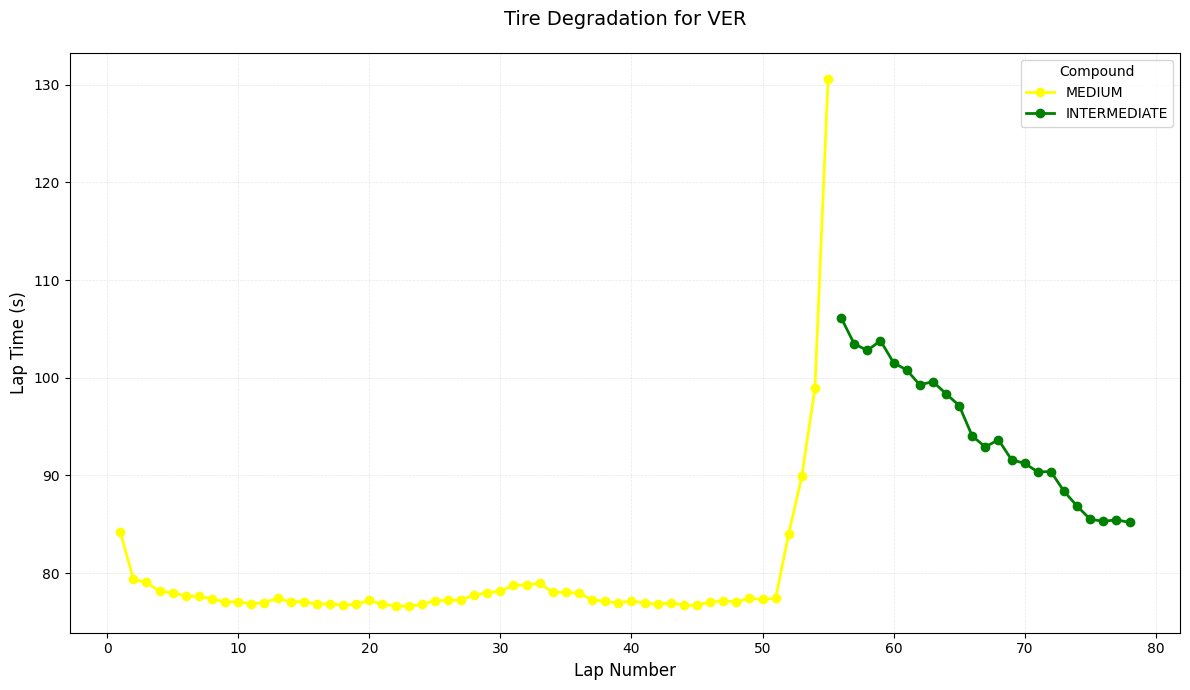

Plotting data for driver: GAS
Compounds for GAS: ['HARD' 'MEDIUM' 'INTERMEDIATE']


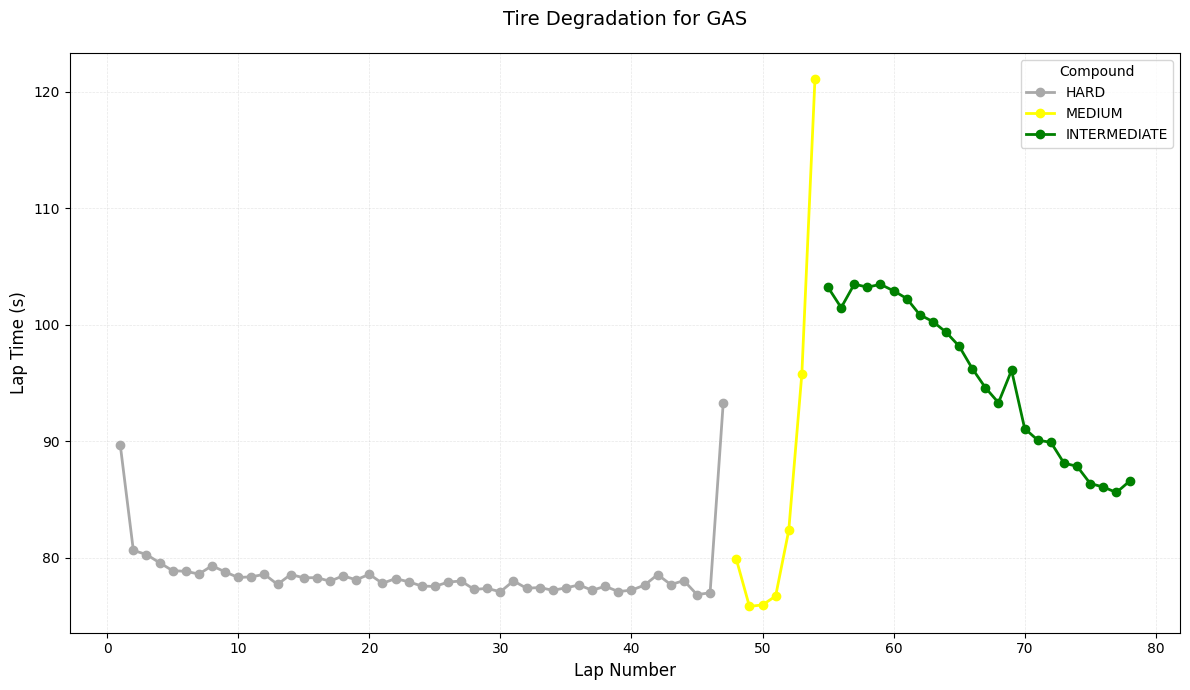

Plotting data for driver: PER
Compounds for PER: ['MEDIUM' 'HARD' 'INTERMEDIATE' 'WET']


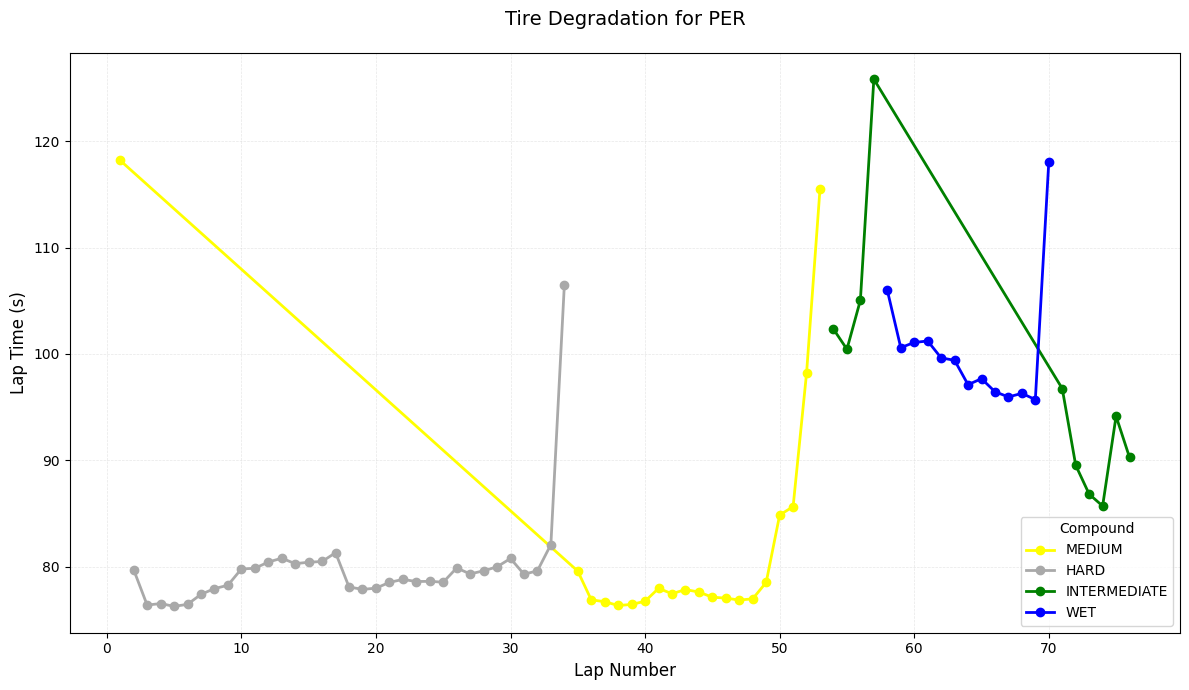

Plotting data for driver: ALO
Compounds for ALO: ['HARD' 'MEDIUM' 'INTERMEDIATE']


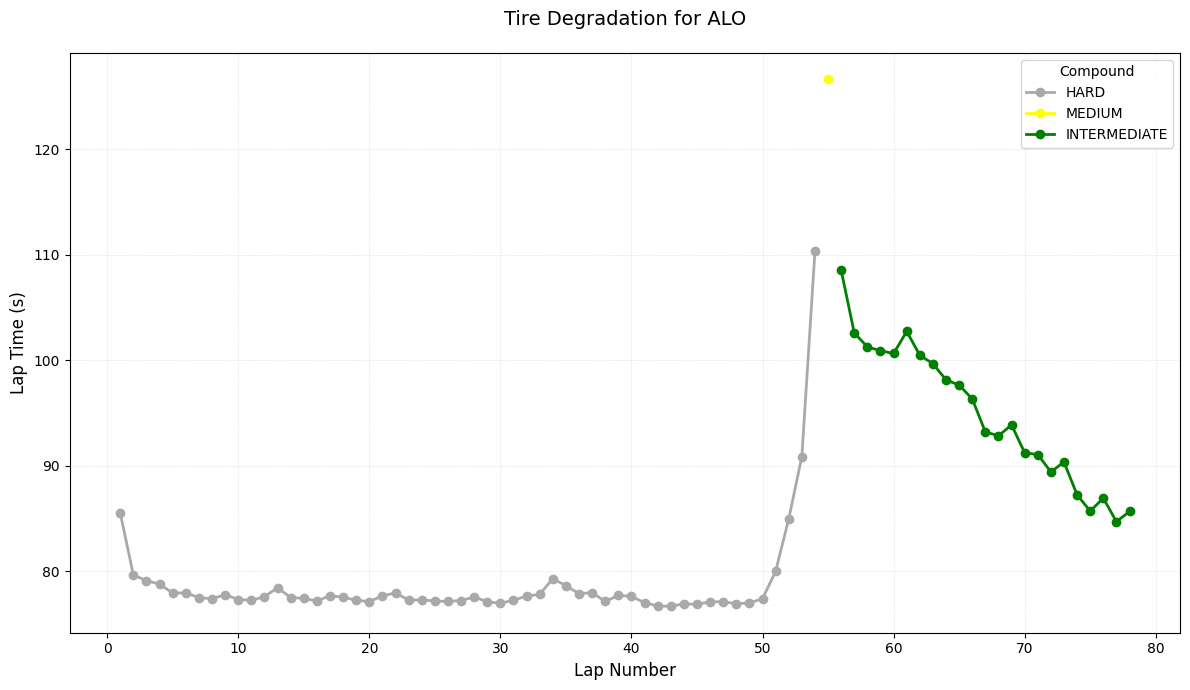

Plotting data for driver: LEC
Compounds for LEC: ['HARD' 'MEDIUM' 'INTERMEDIATE']


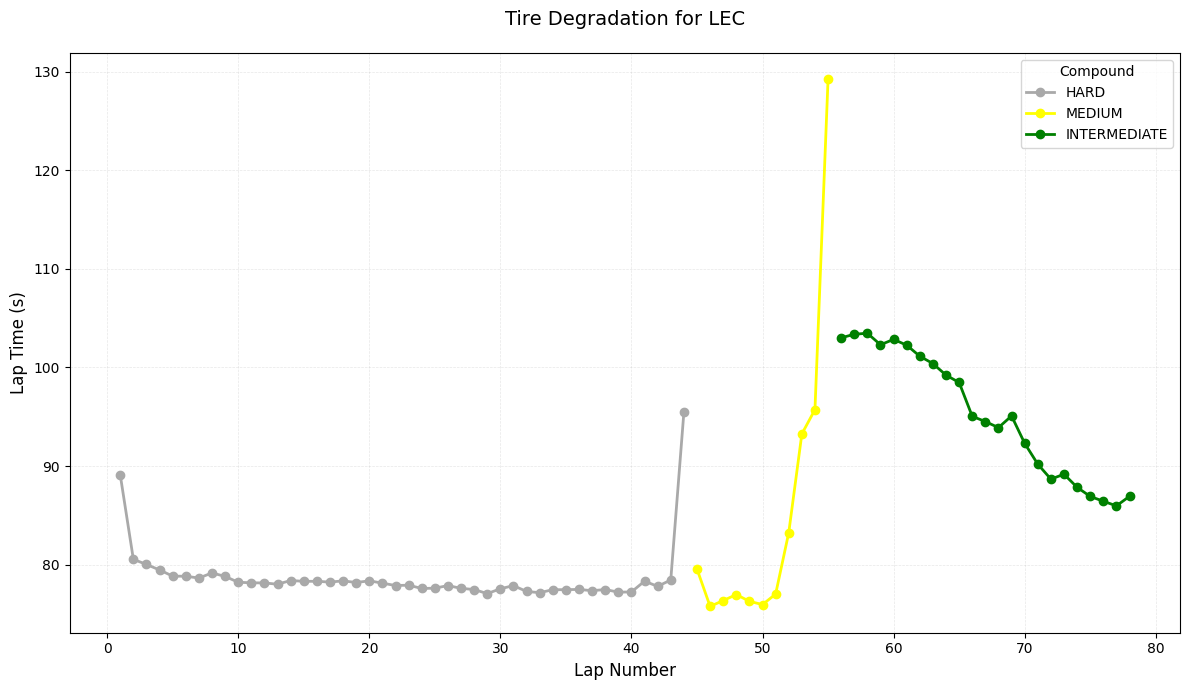

Plotting data for driver: STR
Compounds for STR: ['HARD' 'INTERMEDIATE']


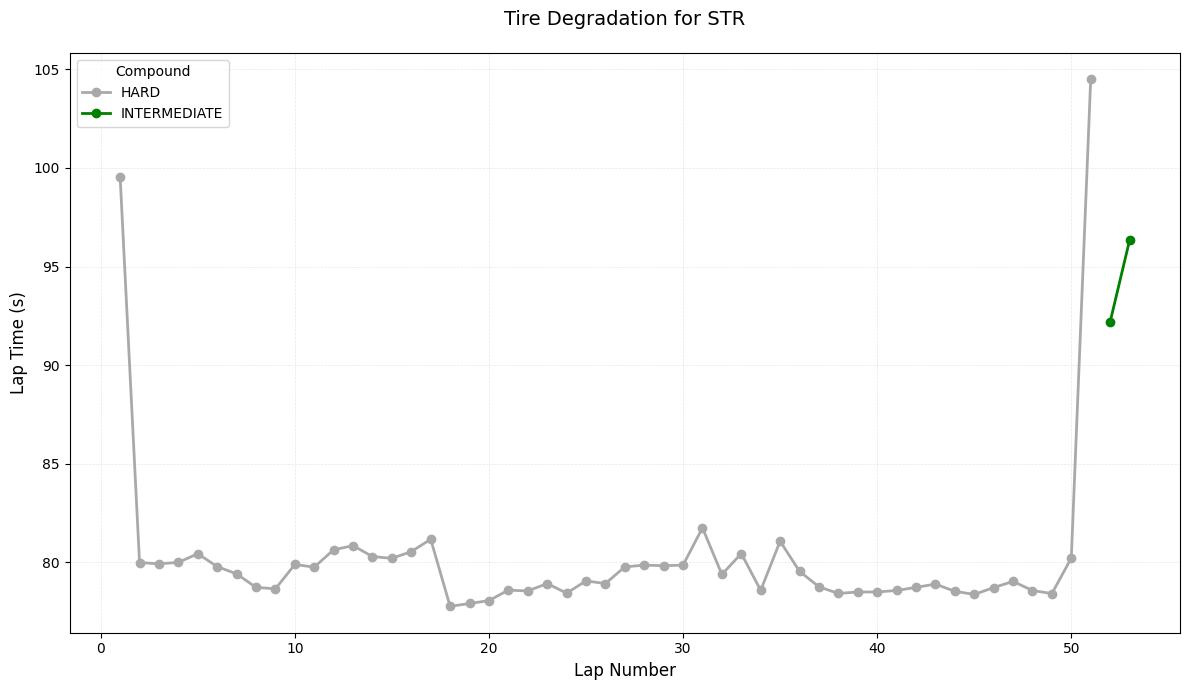

Plotting data for driver: SAR
Compounds for SAR: ['MEDIUM' 'HARD' 'SOFT' 'INTERMEDIATE']


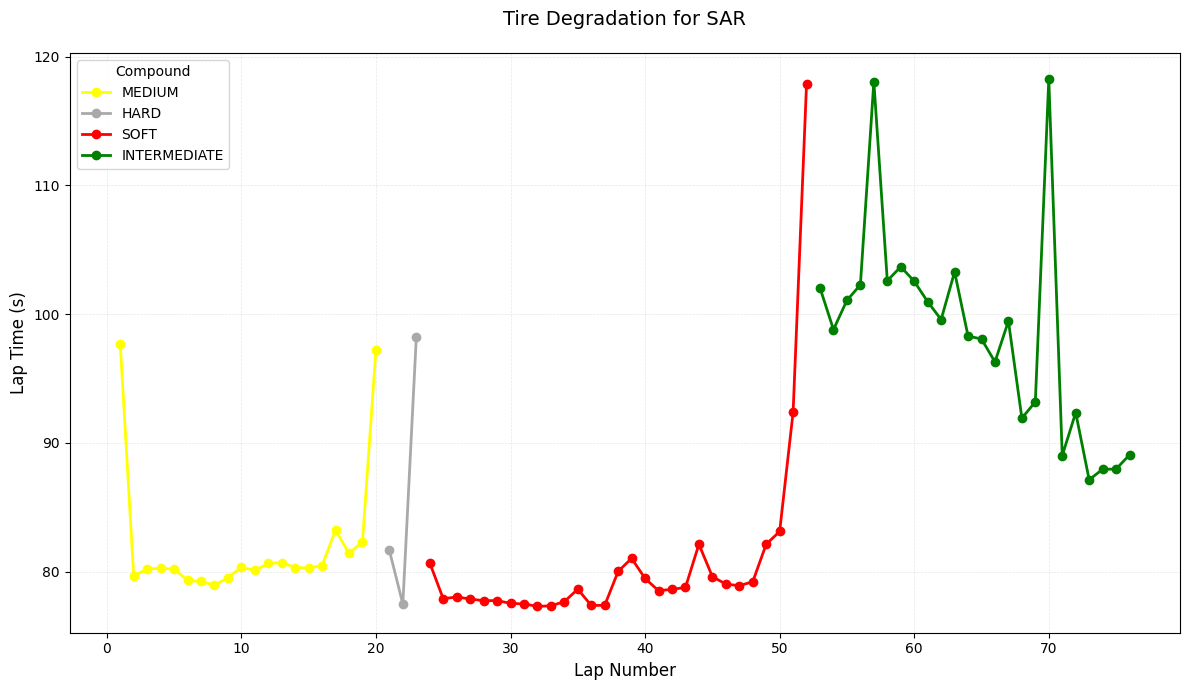

Plotting data for driver: MAG
Compounds for MAG: ['HARD' 'WET']


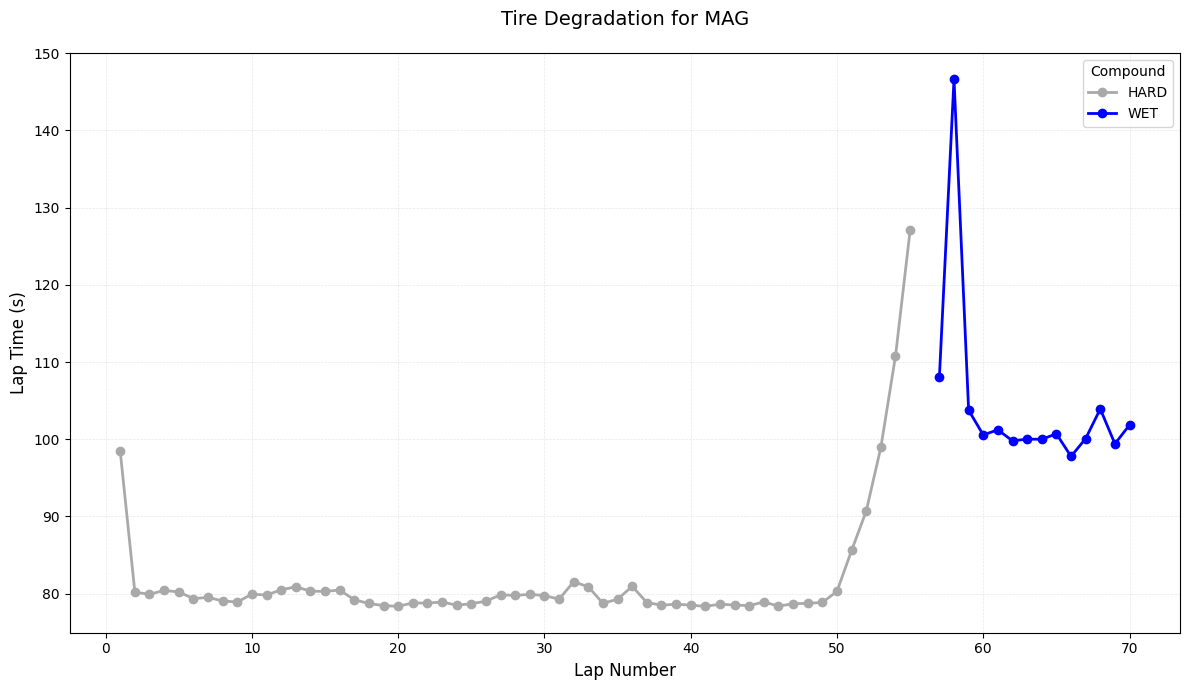

Plotting data for driver: DEV
Compounds for DEV: ['MEDIUM' 'INTERMEDIATE']


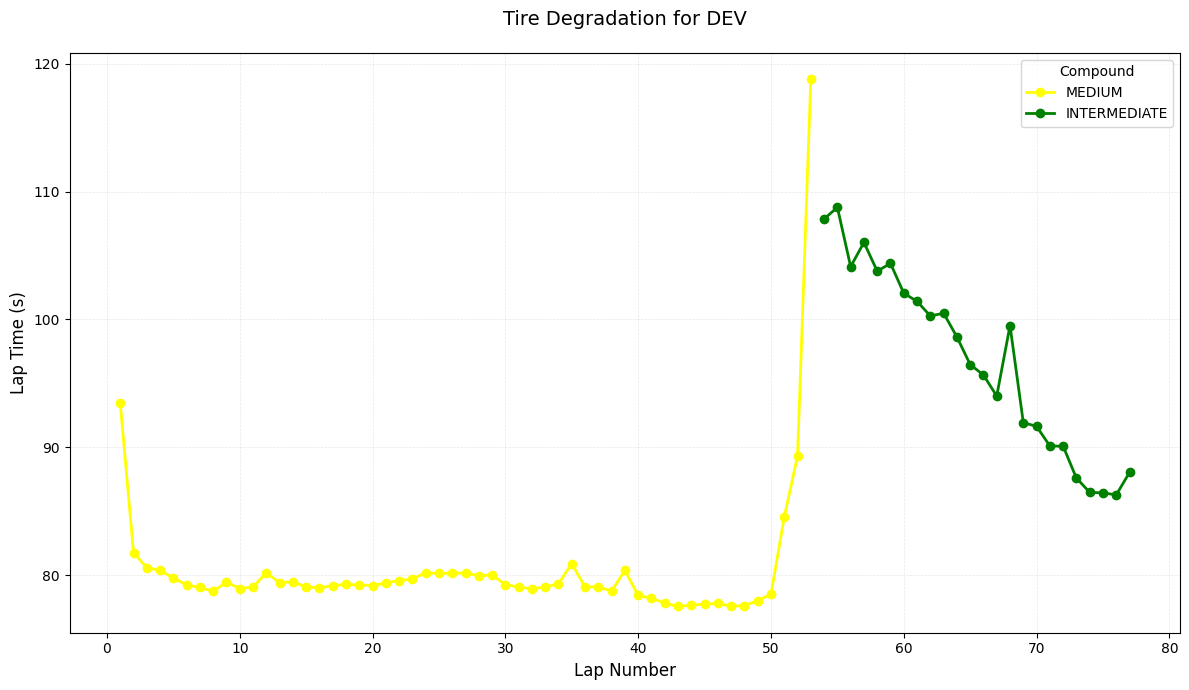

Plotting data for driver: TSU
Compounds for TSU: ['MEDIUM' 'INTERMEDIATE']


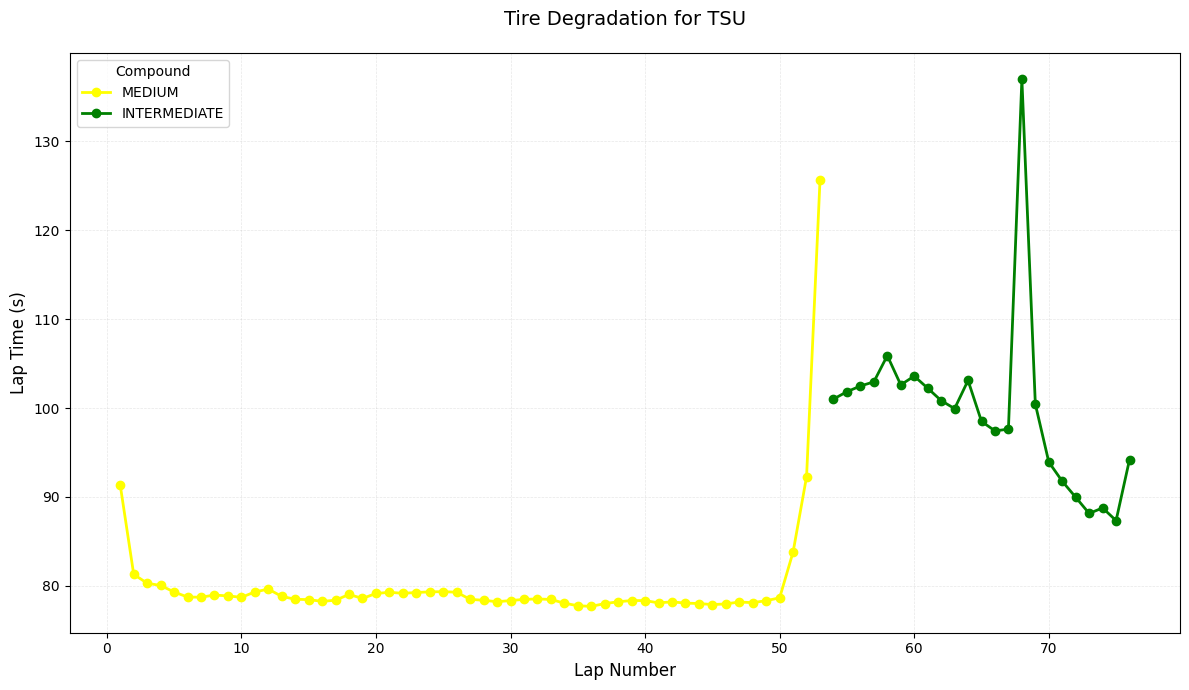

Plotting data for driver: ALB
Compounds for ALB: ['MEDIUM' 'HARD' 'INTERMEDIATE']


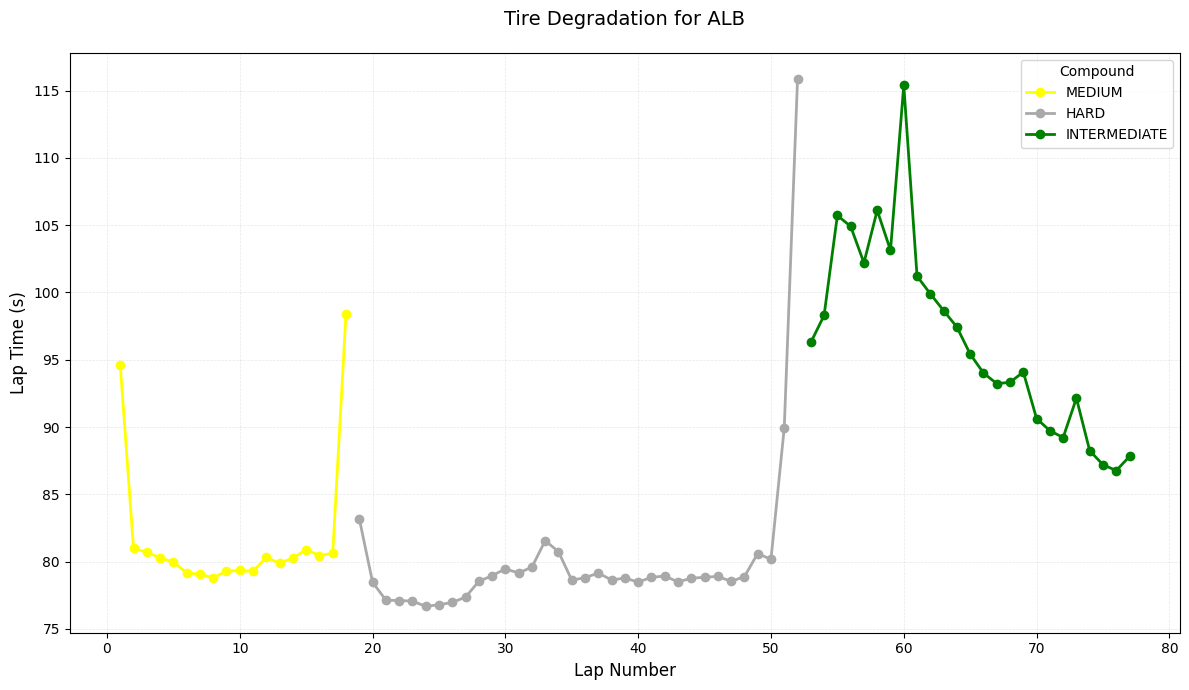

Plotting data for driver: ZHO
Compounds for ZHO: ['SOFT' 'HARD' 'INTERMEDIATE']


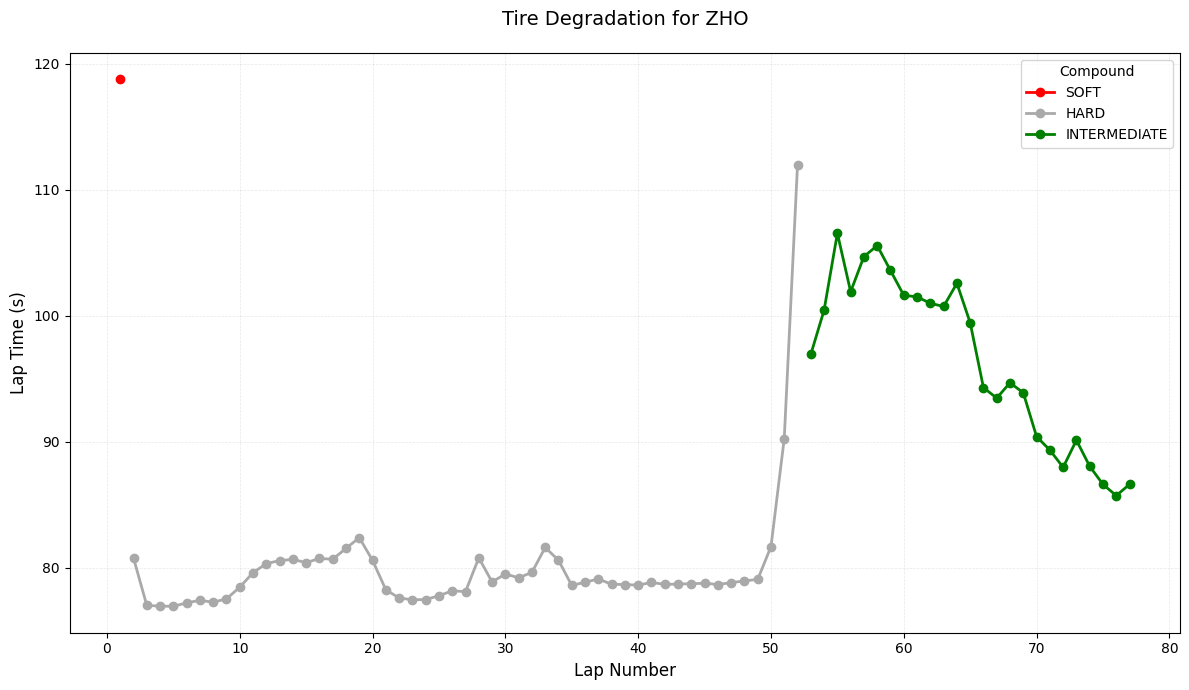

Plotting data for driver: HUL
Compounds for HUL: ['MEDIUM' 'HARD' 'INTERMEDIATE' 'WET']


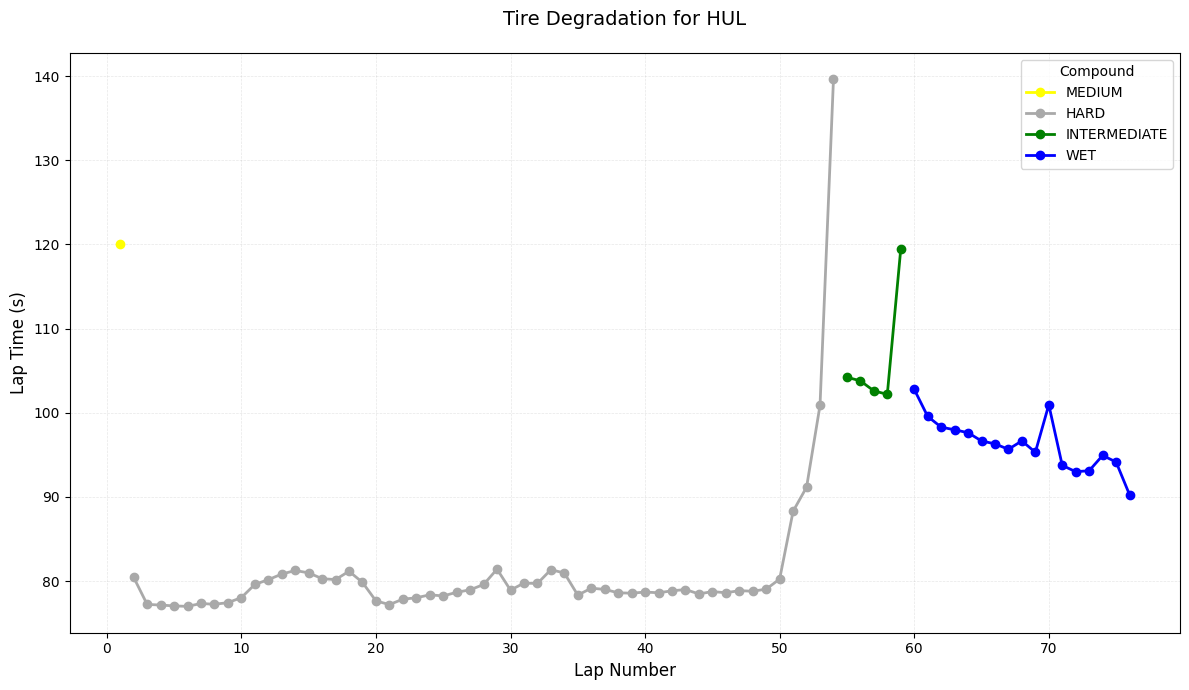

Plotting data for driver: OCO
Compounds for OCO: ['MEDIUM' 'HARD' 'INTERMEDIATE']


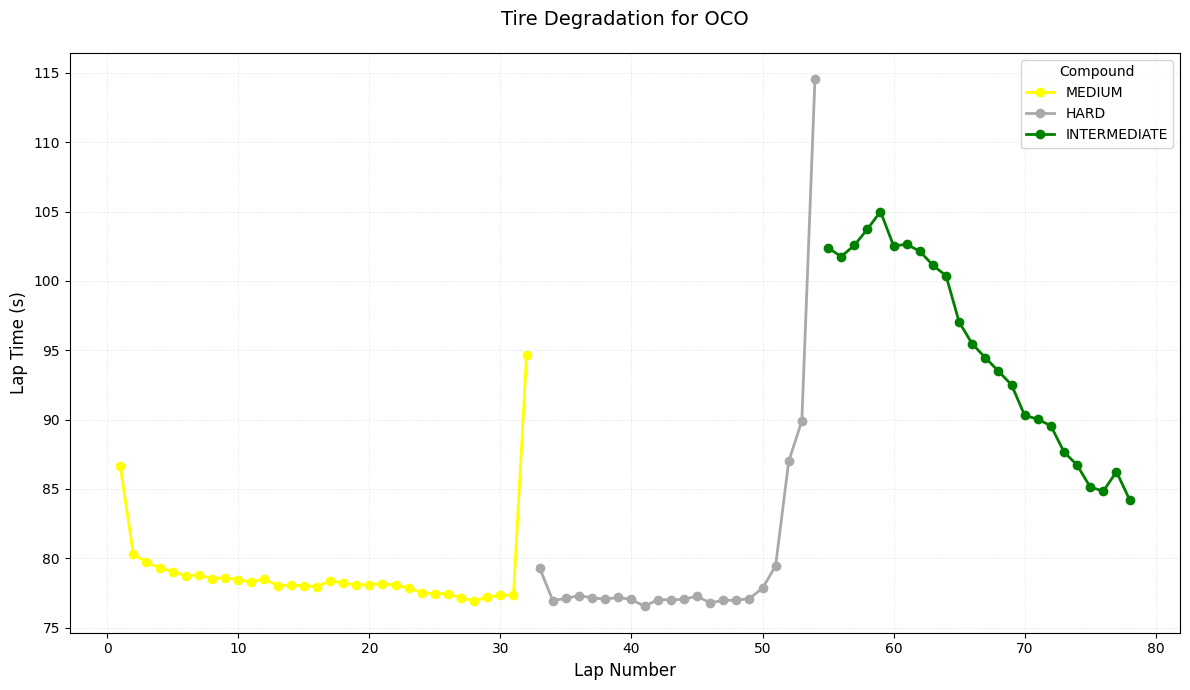

Plotting data for driver: NOR
Compounds for NOR: ['MEDIUM' 'HARD' 'INTERMEDIATE']


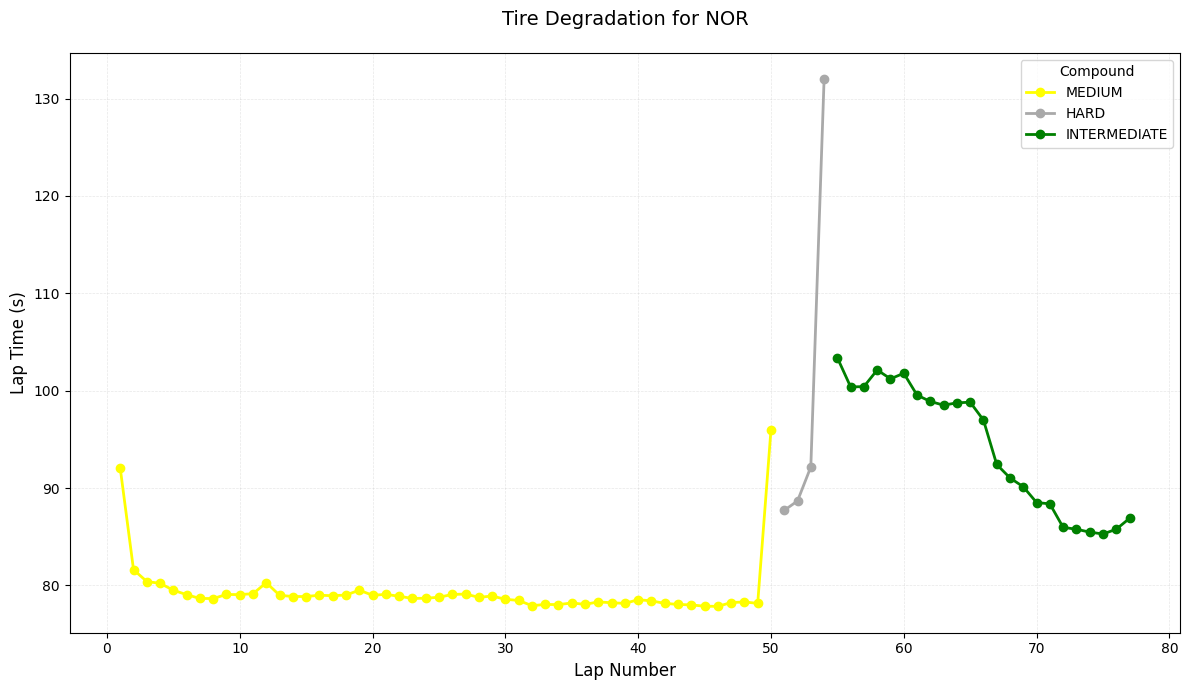

Plotting data for driver: HAM
Compounds for HAM: ['MEDIUM' 'HARD' 'INTERMEDIATE']


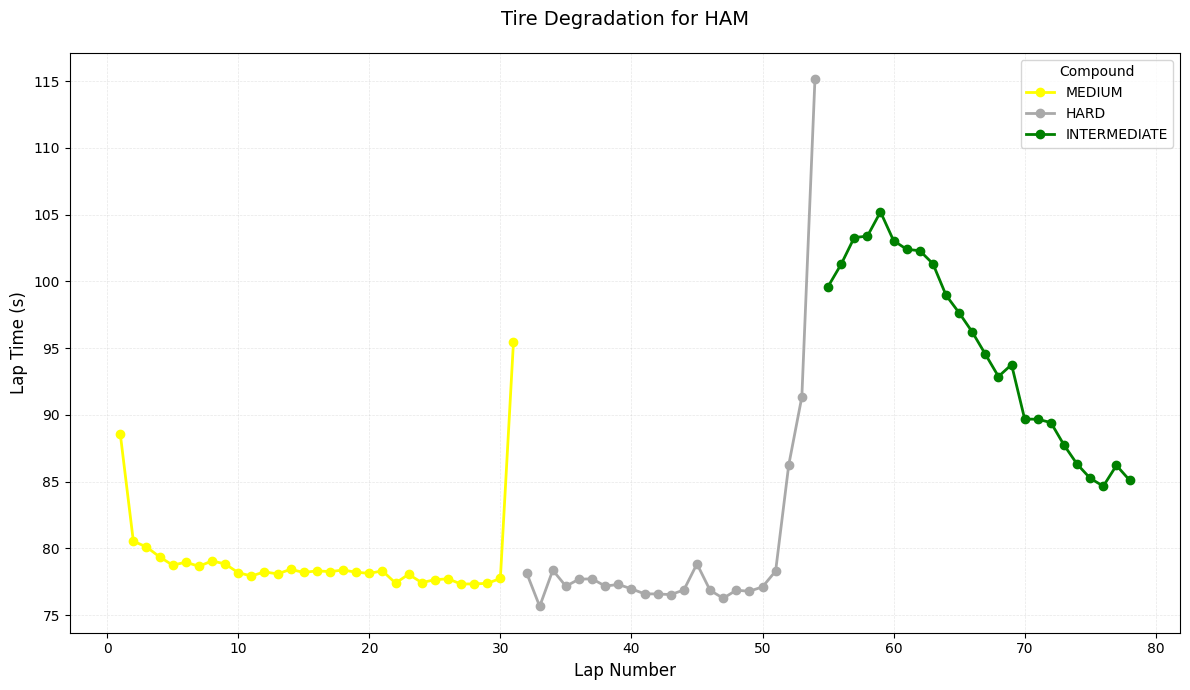

Plotting data for driver: SAI
Compounds for SAI: ['HARD' 'MEDIUM' 'INTERMEDIATE']


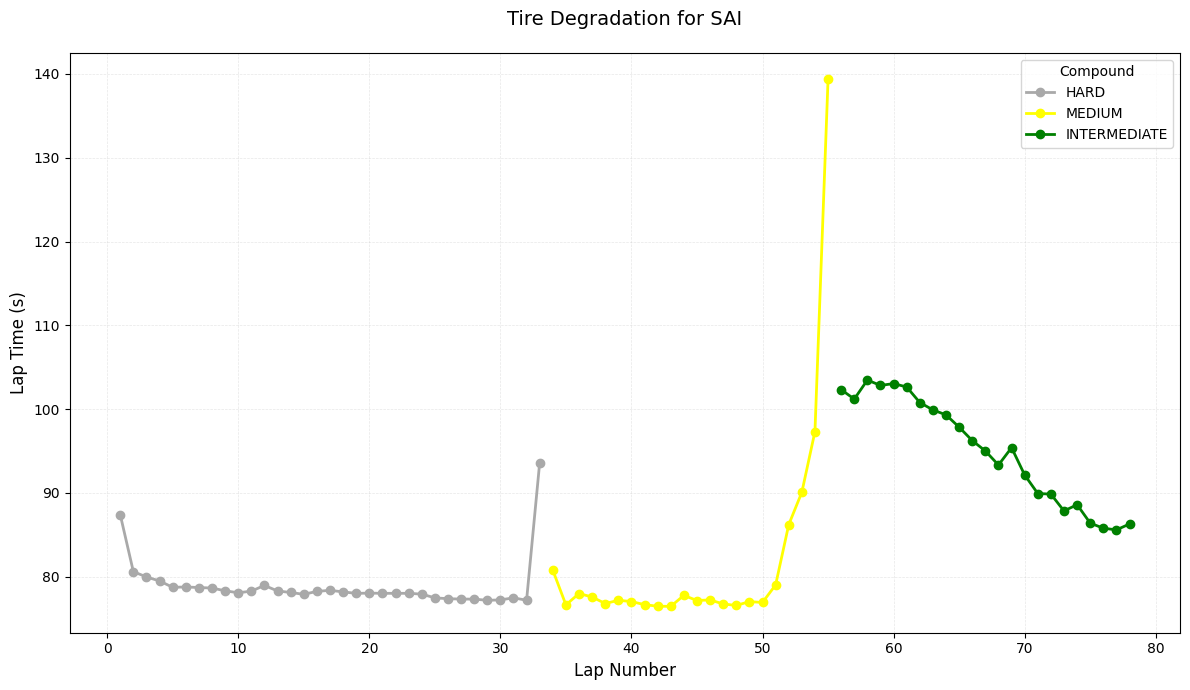

Plotting data for driver: RUS
Compounds for RUS: ['HARD' 'INTERMEDIATE']


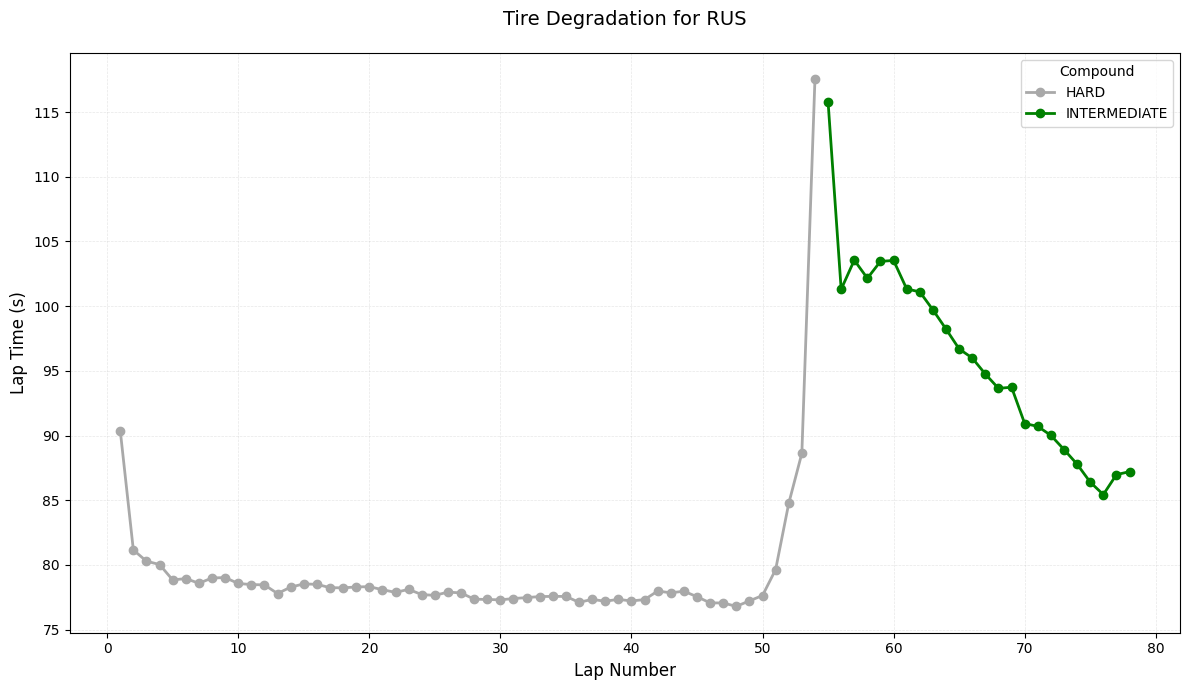

Plotting data for driver: BOT
Compounds for BOT: ['HARD' 'INTERMEDIATE']


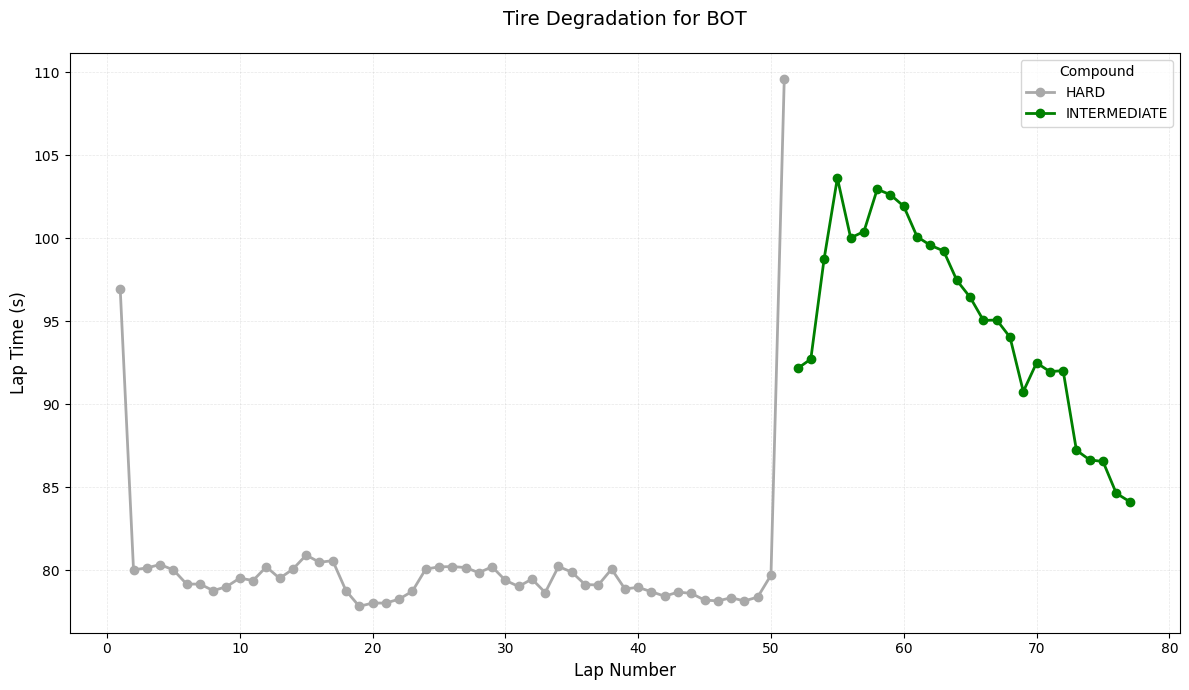

Plotting data for driver: PIA
Compounds for PIA: ['HARD' 'INTERMEDIATE']


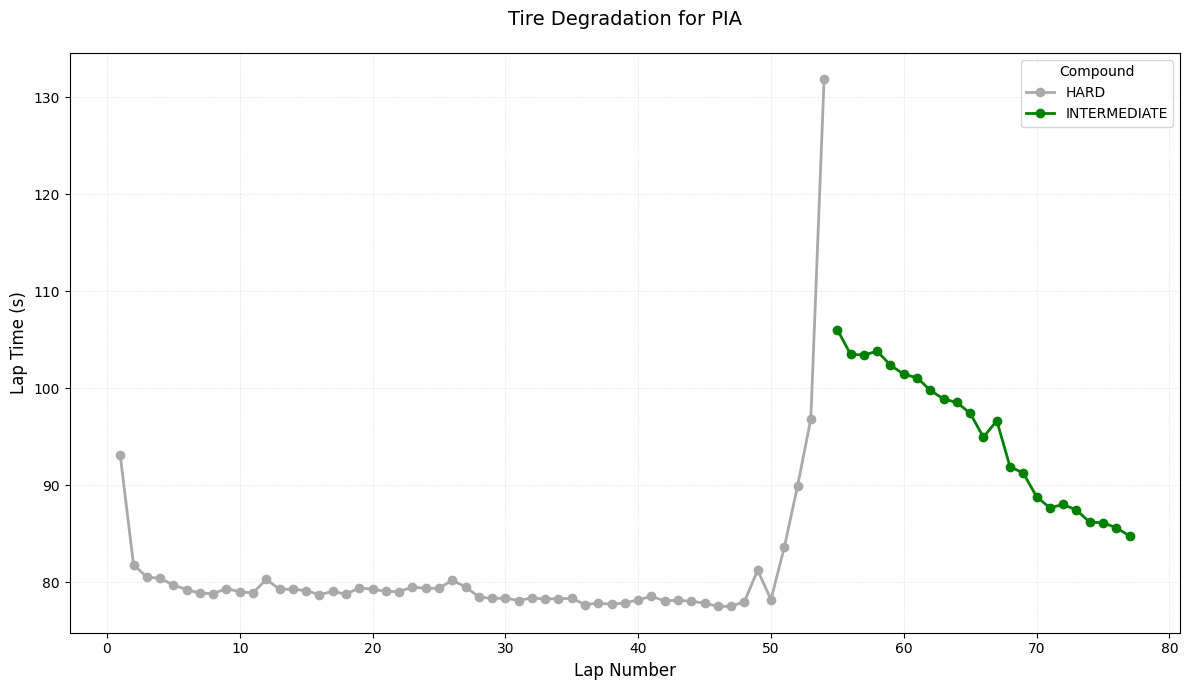

In [22]:
if __name__ == "__main__":
    main()